# Домашнее задание 2: Создание и оптимизация ResNet18

Общая цель
Поэтапная разработка кастомной ResNet18 модели для классификации Tiny ImageNet с анализом влияния различных архитектурных решений на производительность.

Датасет: Tiny ImageNet (200 классов) - выберите 10 классов самостоятельно для работы

Часть 1: Подготовка данных
Создание датакласса
Реализуйте собственный класс TinyImageNetDataset, наследующий от torch.utils.data.Dataset:

Метод __init__: инициализация путей к данным, загрузка списка изображений и меток
Метод __len__: возврат количества примеров в датасете
Метод __getitem__: загрузка и возврат одного примера (изображение + метка)

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2025-12-17 12:51:39--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-12-17 12:51:39--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  35.7MB/s    in 5.9s    

2025-12-17 12:51:45 (39.9 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [2]:
!unzip -q tiny-imagenet-200.zip

In [3]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

import glob

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
SELECTED_CLASSES = ['n01443537', 'n01641577', 'n01698610', 'n01742172', 'n01882714', 'n02002724', 'n02056570', 'n02099601', 'n02123045']
print(f"Выбранные классы: {SELECTED_CLASSES}")

Выбранные классы: ['n01443537', 'n01641577', 'n01698610', 'n01742172', 'n01882714', 'n02002724', 'n02056570', 'n02099601', 'n02123045']


## Часть 1: Подготовка данных

In [5]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, selected_classes, split='train', transform=None):
        """
        Args:
            root_dir: путь к корневой директории Tiny ImageNet
            selected_classes: список ID классов
            split: 'train' или 'val'
            transform: трансформации для изображений
        """
        self.root_dir = root_dir
        self.selected_classes = SELECTED_CLASSES
        self.split = split
        self.transform = transform

        # Маппинг класс -> индекс
        self.class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}

        # Инициализация путей к данным, загрузка списка изображений и меток
        self.image_paths = []
        self.labels = []

        if split == 'train':
            self._load_train_data()
        elif split == 'val':
            self._load_val_data()

    def _load_train_data(self):
        train_dir = os.path.join(self.root_dir, 'train')

        for class_id in self.selected_classes:
            class_dir = os.path.join(train_dir, class_id, 'images')
            image_files = glob.glob(os.path.join(class_dir, '*.JPEG'))

            for img_path in image_files:
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_id])

    def _load_val_data(self):
        val_dir = os.path.join(self.root_dir, 'val')
        val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

        with open(val_annotations_file, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                img_name = parts[0]
                class_id = parts[1]

                if class_id in self.selected_classes:
                    img_path = os.path.join(val_dir, 'images', img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_id])

    def __len__(self):
        """Возврат количества примеров в датасете"""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Загрузка и возврат одного примера (изображение + метка)"""
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

## Часть 2: Базовая архитектура ResNet18


### 2.1. Реализация Basic Block

In [6]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### 2.2. Реализация ResNet18

In [7]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []

        layers.append(BasicBlock(in_channels, out_channels, stride))

        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

### 2.3. Ограничения для базовой модели:
*   Общее количество параметров: не более 5 миллионов
*   Максимальное количество каналов: до 512

In [8]:
def count_parameters(model):
    """Подсчет общего количества параметров модели"""
    return sum(p.numel() for p in model.parameters())

model = ResNet18(num_classes=10)

total_params = count_parameters(model)
print(f"Общее количество параметров: {total_params:,} ({total_params/1e6:.2f}M)")

Общее количество параметров: 2,777,674 (2.78M)


### 2.4. Скрипт обучения

In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Обучение на одной эпохе"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Валидация модели"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs=30, lr=0.001, device='cuda'):
    """Полный цикл обучения"""
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return history

TINY_IMAGENET_PATH = '/content/tiny-imagenet-200'

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TinyImageNetDataset(TINY_IMAGENET_PATH, SELECTED_CLASSES, 'train', train_transform)
val_dataset = TinyImageNetDataset(TINY_IMAGENET_PATH, SELECTED_CLASSES, 'val', val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используется устройство: {device}')

model = ResNet18(num_classes=10)
print(f'Количество параметров: {count_parameters(model):,}')

history = train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

Используется устройство: cuda
Количество параметров: 2,777,674
Epoch [1/20] Train Loss: 1.6808, Train Acc: 40.02% | Val Loss: 1.6659, Val Acc: 39.25%
Epoch [2/20] Train Loss: 1.3934, Train Acc: 50.95% | Val Loss: 2.3711, Val Acc: 34.75%
Epoch [3/20] Train Loss: 1.2969, Train Acc: 54.27% | Val Loss: 1.3092, Val Acc: 51.75%
Epoch [4/20] Train Loss: 1.1896, Train Acc: 58.75% | Val Loss: 1.2889, Val Acc: 54.75%
Epoch [5/20] Train Loss: 1.1242, Train Acc: 61.00% | Val Loss: 1.1938, Val Acc: 57.25%
Epoch [6/20] Train Loss: 1.0495, Train Acc: 63.90% | Val Loss: 1.4964, Val Acc: 52.25%
Epoch [7/20] Train Loss: 0.9998, Train Acc: 66.28% | Val Loss: 1.2241, Val Acc: 55.25%
Epoch [8/20] Train Loss: 0.9900, Train Acc: 65.53% | Val Loss: 1.2833, Val Acc: 53.25%
Epoch [9/20] Train Loss: 0.9302, Train Acc: 68.05% | Val Loss: 1.1387, Val Acc: 59.00%
Epoch [10/20] Train Loss: 0.8564, Train Acc: 71.53% | Val Loss: 1.2827, Val Acc: 54.25%
Epoch [11/20] Train Loss: 0.8257, Train Acc: 72.20% | Val Loss: 1.

### 2.5: Визуализация базовых результатов

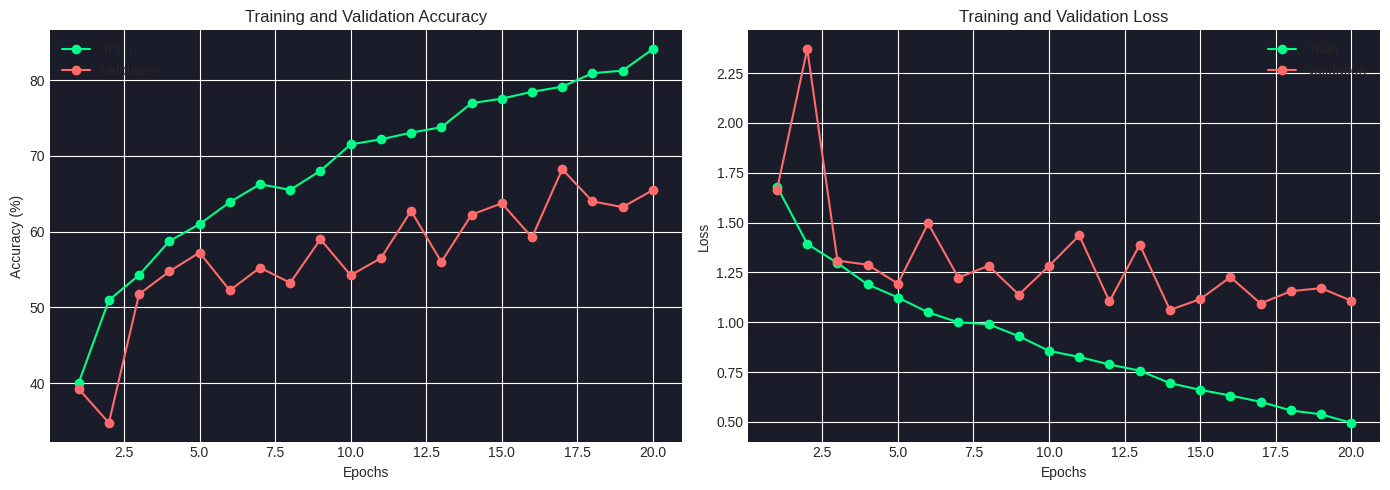

Общее количество параметров: 2,777,674

Архитектура модели:
ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64

In [10]:
def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.style.use('seaborn-v0_8-darkgrid')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(epochs, history['train_acc'], label='Train', marker='o',color='#00ff88')
    ax1.plot(epochs, history['val_acc'], label='Validation', marker='o', color='#ff6b6b')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_facecolor('#1a1d29')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, history['train_loss'], label='Train', marker='o',color='#00ff88')
    ax2.plot(epochs, history['val_loss'], label='Validation', marker='o',color='#ff6b6b')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_facecolor('#1a1d29')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_results(history)

print(f"Общее количество параметров: {count_parameters(model):,}")
print("\nАрхитектура модели:")
print(model)

## Часть 3: Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

ВАРИАНТ A:
Количество параметров: 2,797,610
Epoch [1/20] Train Loss: 1.6606, Train Acc: 40.48% | Val Loss: 2.8265, Val Acc: 26.75%
Epoch [2/20] Train Loss: 1.3391, Train Acc: 52.77% | Val Loss: 1.5480, Val Acc: 47.00%
Epoch [3/20] Train Loss: 1.2230, Train Acc: 56.83% | Val Loss: 1.5588, Val Acc: 43.50%
Epoch [4/20] Train Loss: 1.1529, Train Acc: 59.67% | Val Loss: 1.4714, Val Acc: 50.50%
Epoch [5/20] Train Loss: 1.0356, Train Acc: 64.17% | Val Loss: 1.1868, Val Acc: 58.75%
Epoch [6/20] Train Loss: 0.9548, Train Acc: 67.12% | Val Loss: 1.6268, Val Acc: 50.75%
Epoch [7/20] Train Loss: 0.8828, Train Acc: 69.70% | Val Loss: 1.1910, Val Acc: 60.25%
Epoch [8/20] Train Loss: 0.8141, Train Acc: 72.53% | Val Loss: 1.3322, Val Acc: 58.25%
Epoch [9/20] Train Loss: 0.7498, Train Acc: 75.00% | Val Loss: 1.2474, Val Acc: 61.00%
Epoch [10/20] Train Loss: 0.7083, Train Acc: 75.67% | Val Loss: 1.4058, Val Acc: 61.00%
Epoch [11/20] Train Loss: 0.6515, Train Acc: 77.83% | Val Loss: 1.0991, Val Acc: 61.5

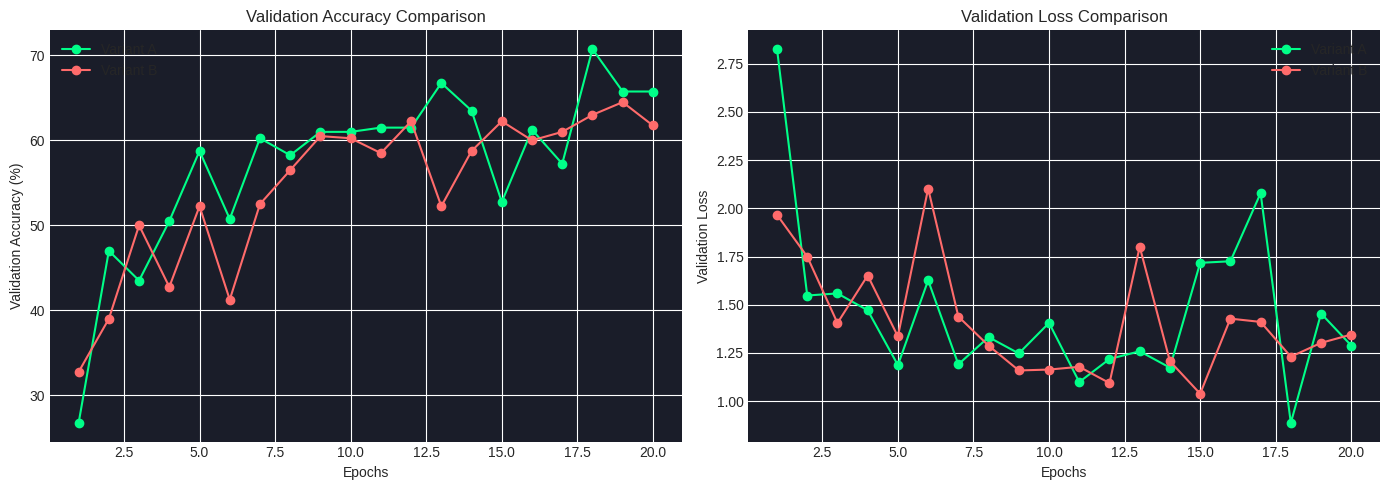

In [11]:
class ResNet18_VariantA(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_VariantA, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(32, 32, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

class ResNet18_VariantB(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_VariantB, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

print("ВАРИАНТ A:")
model_A = ResNet18_VariantA(num_classes=10)
print(f'Количество параметров: {count_parameters(model_A):,}')

history_A = train_model(model_A, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("ВАРИАНТ B:")
model_B = ResNet18_VariantB(num_classes=10)
print(f'Количество параметров: {count_parameters(model_B):,}')

history_B = train_model(model_B, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print(f"Вариант A - Параметры: {count_parameters(model_A):,}, Val Accuracy: {max(history_A['val_acc']):.2f}%")
print(f"Вариант B - Параметры: {count_parameters(model_B):,}, Val Accuracy: {max(history_B['val_acc']):.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history_A['train_acc']) + 1)

# Accuracy
ax1.plot(epochs, history_A['val_acc'], label='Variant A', marker='o', color='#00ff88')
ax1.plot(epochs, history_B['val_acc'], label='Variant B', marker='o', color='#ff6b6b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Accuracy (%)')
ax1.set_title('Validation Accuracy Comparison')
ax1.set_facecolor('#1a1d29')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(epochs, history_A['val_loss'], label='Variant A', marker='o', color='#00ff88')
ax2.plot(epochs, history_B['val_loss'], label='Variant B', marker='o', color='#ff6b6b')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Comparison')
ax2.set_facecolor('#1a1d29')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Вывод:
* Вариант A: 2.8M параметров, лучшая валидационная точность = 70.75%.
* Вариант B: 2.8M параметров, лучшая валидационная точность = 64.50%.
Архитектура с четырьмя слоями (A) показала значимо лучшее качество, несмотря на схожее количество параметров с трёхслойной (B).

### 3.2: Эксперименты с количеством residual блоков

ВАРИАНТ A:
Количество параметров: 1,228,970
Epoch [1/20] Train Loss: 1.5769, Train Acc: 44.17% | Val Loss: 1.6943, Val Acc: 41.25%
Epoch [2/20] Train Loss: 1.2875, Train Acc: 54.35% | Val Loss: 1.7569, Val Acc: 38.50%
Epoch [3/20] Train Loss: 1.1340, Train Acc: 60.65% | Val Loss: 1.4458, Val Acc: 48.75%
Epoch [4/20] Train Loss: 1.0364, Train Acc: 64.72% | Val Loss: 1.6495, Val Acc: 50.25%
Epoch [5/20] Train Loss: 0.9407, Train Acc: 68.65% | Val Loss: 1.5808, Val Acc: 50.00%
Epoch [6/20] Train Loss: 0.8642, Train Acc: 71.50% | Val Loss: 1.4777, Val Acc: 50.00%
Epoch [7/20] Train Loss: 0.8058, Train Acc: 73.00% | Val Loss: 1.2534, Val Acc: 59.25%
Epoch [8/20] Train Loss: 0.7095, Train Acc: 76.20% | Val Loss: 1.2363, Val Acc: 56.75%
Epoch [9/20] Train Loss: 0.6234, Train Acc: 79.05% | Val Loss: 1.1952, Val Acc: 59.50%
Epoch [10/20] Train Loss: 0.5478, Train Acc: 81.58% | Val Loss: 1.1474, Val Acc: 60.25%
Epoch [11/20] Train Loss: 0.4583, Train Acc: 85.15% | Val Loss: 1.4467, Val Acc: 58.5

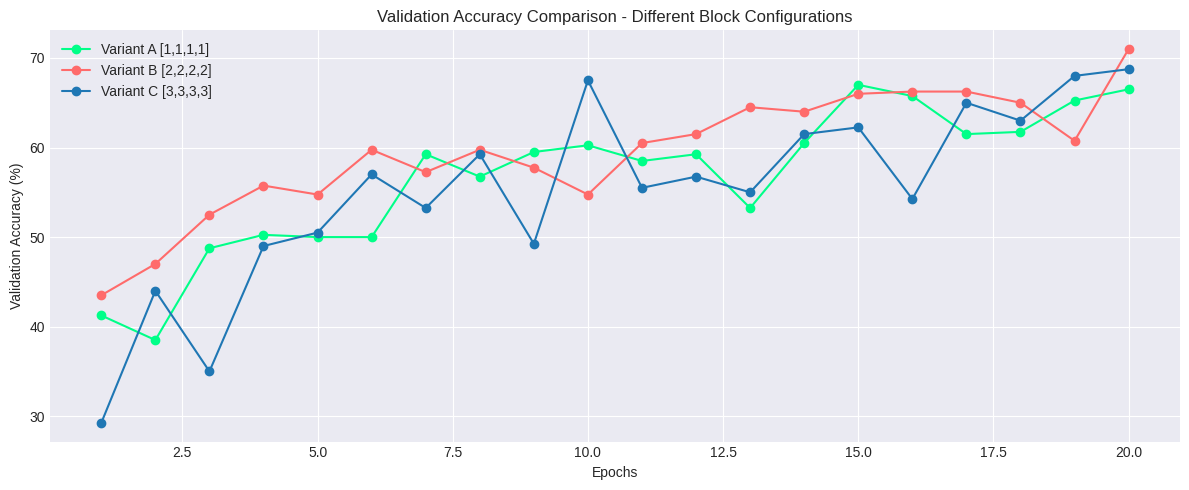

In [12]:
class ResNet18_Flexible(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[2, 2, 2, 2]):
        super(ResNet18_Flexible, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(32, 32, num_blocks=num_blocks[0], stride=1)
        self.layer2 = self._make_layer(32, 64, num_blocks=num_blocks[1], stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=num_blocks[2], stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое
print("ВАРИАНТ A:")
model_blocks_A = ResNet18_Flexible(num_classes=10, num_blocks=[1, 1, 1, 1])
print(f'Количество параметров: {count_parameters(model_blocks_A):,}')

history_blocks_A = train_model(model_blocks_A, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

# Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое
print("ВАРИАНТ B:")
model_blocks_B = ResNet18_Flexible(num_classes=10, num_blocks=[2, 2, 2, 2])
print(f'Количество параметров: {count_parameters(model_blocks_B):,}')

history_blocks_B = train_model(model_blocks_B, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

# Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое
print("ВАРИАНТ C:")
model_blocks_C = ResNet18_Flexible(num_classes=10, num_blocks=[3, 3, 3, 3])
print(f'Количество параметров: {count_parameters(model_blocks_C):,}')

history_blocks_C = train_model(model_blocks_C, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print(f"Вариант A [1,1,1,1] - Val Accuracy: {max(history_blocks_A['val_acc']):.2f}%")
print(f"Вариант B [2,2,2,2] - Val Accuracy: {max(history_blocks_B['val_acc']):.2f}%")
print(f"Вариант C [3,3,3,3] - Val Accuracy: {max(history_blocks_C['val_acc']):.2f}%")

plt.figure(figsize=(12, 5))

epochs = range(1, len(history_blocks_A['val_acc']) + 1)

plt.plot(epochs, history_blocks_A['val_acc'], label='Variant A [1,1,1,1]', marker='o', color='#00ff88')
plt.plot(epochs, history_blocks_B['val_acc'], label='Variant B [2,2,2,2]', marker='o', color='#ff6b6b')
plt.plot(epochs, history_blocks_C['val_acc'], label='Variant C [3,3,3,3]', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison - Different Block Configurations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Вывод:
У самой глубокой модели (12 блоков, Вариант C) наблюдался самый высокий разрыв между train loss и val loss, а также нестабильная динамика val accuracy, что указывает на переобучение.
Сеть с 8 блоками (Вариант B) достигла наивысшей валидационной точности (~71%).

### 3.3: Эксперименты с функциями активации

ВАРИАНТ A: ReLU
Количество параметров: 1,228,970
Epoch [1/20] Train Loss: 1.5870, Train Acc: 42.48% | Val Loss: 1.7571, Val Acc: 36.75%
Epoch [2/20] Train Loss: 1.2637, Train Acc: 55.58% | Val Loss: 1.7500, Val Acc: 39.75%
Epoch [3/20] Train Loss: 1.1350, Train Acc: 61.35% | Val Loss: 1.4144, Val Acc: 50.50%
Epoch [4/20] Train Loss: 1.0147, Train Acc: 65.62% | Val Loss: 1.2134, Val Acc: 56.50%
Epoch [5/20] Train Loss: 0.9403, Train Acc: 67.95% | Val Loss: 1.7488, Val Acc: 52.50%
Epoch [6/20] Train Loss: 0.8367, Train Acc: 71.45% | Val Loss: 1.2278, Val Acc: 56.25%
Epoch [7/20] Train Loss: 0.7572, Train Acc: 74.75% | Val Loss: 1.6583, Val Acc: 49.50%
Epoch [8/20] Train Loss: 0.6521, Train Acc: 78.38% | Val Loss: 1.3073, Val Acc: 55.00%
Epoch [9/20] Train Loss: 0.5792, Train Acc: 79.88% | Val Loss: 1.5389, Val Acc: 59.25%
Epoch [10/20] Train Loss: 0.4780, Train Acc: 84.50% | Val Loss: 1.4237, Val Acc: 55.00%
Epoch [11/20] Train Loss: 0.4137, Train Acc: 86.67% | Val Loss: 1.7112, Val Acc:

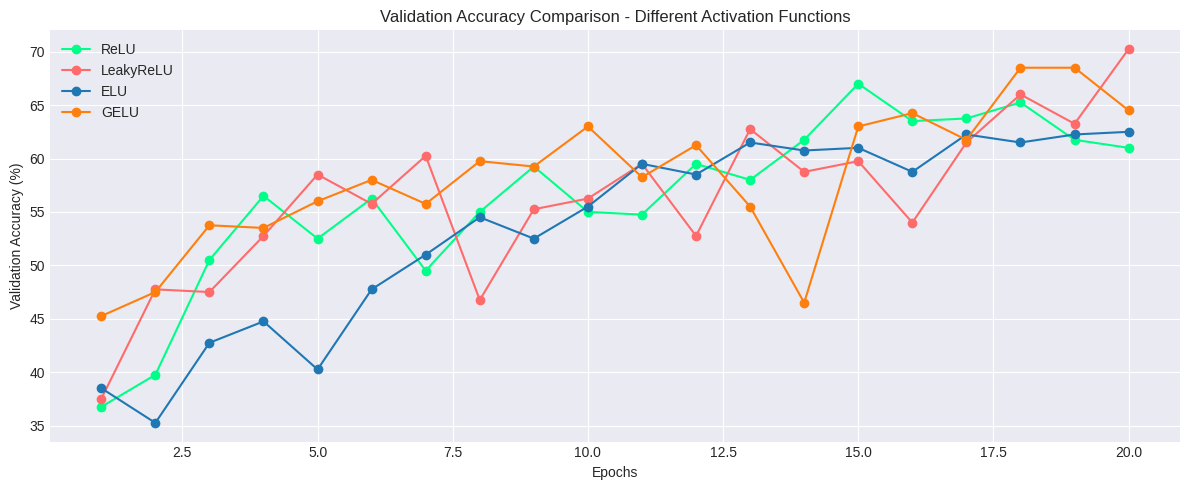

In [13]:
class BasicBlock_CustomActivation(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation='relu'):
        super(BasicBlock_CustomActivation, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Выбор функции активации
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()

        # Skip connection
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.activation(out)

        return out

class ResNet18_CustomActivation(nn.Module):
    def __init__(self, num_classes=10, activation='relu'):
        super(ResNet18_CustomActivation, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()

        self.layer1 = self._make_layer(32, 32, num_blocks=1, stride=1, activation=activation)
        self.layer2 = self._make_layer(32, 64, num_blocks=1, stride=2, activation=activation)
        self.layer3 = self._make_layer(64, 128, num_blocks=1, stride=2, activation=activation)
        self.layer4 = self._make_layer(128, 256, num_blocks=1, stride=2, activation=activation)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride, activation):
        layers = []
        layers.append(BasicBlock_CustomActivation(in_channels, out_channels, stride=stride, activation=activation))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock_CustomActivation(out_channels, out_channels, stride=1, activation=activation))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

print("ВАРИАНТ A: ReLU")
model_relu = ResNet18_CustomActivation(num_classes=10, activation='relu')
print(f'Количество параметров: {count_parameters(model_relu):,}')

history_relu = train_model(model_relu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("ВАРИАНТ B: LeakyReLU")
model_leakyrelu = ResNet18_CustomActivation(num_classes=10, activation='leakyrelu')
print(f'Количество параметров: {count_parameters(model_leakyrelu):,}')

history_leakyrelu = train_model(model_leakyrelu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("ВАРИАНТ C: ELU")
model_elu = ResNet18_CustomActivation(num_classes=10, activation='elu')
print(f'Количество параметров: {count_parameters(model_elu):,}')

history_elu = train_model(model_elu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print("ВАРИАНТ D: GELU")
model_gelu = ResNet18_CustomActivation(num_classes=10, activation='gelu')
print(f'Количество параметров: {count_parameters(model_gelu):,}')

history_gelu = train_model(model_gelu, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)

print(f"ReLU - Val Accuracy: {max(history_relu['val_acc']):.2f}%")
print(f"LeakyReLU - Val Accuracy: {max(history_leakyrelu['val_acc']):.2f}%")
print(f"ELU - Val Accuracy: {max(history_elu['val_acc']):.2f}%")
print(f"GELU - Val Accuracy: {max(history_gelu['val_acc']):.2f}%")

plt.figure(figsize=(12, 5))

epochs = range(1, len(history_relu['val_acc']) + 1)

plt.plot(epochs, history_relu['val_acc'], label='ReLU', marker='o', color='#00ff88')
plt.plot(epochs, history_leakyrelu['val_acc'], label='LeakyReLU', marker='o', color='#ff6b6b')
plt.plot(epochs, history_elu['val_acc'], label='ELU', marker='o')
plt.plot(epochs, history_gelu['val_acc'], label='GELU', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison - Different Activation Functions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Вывод:
Классический ReLU показал наилучший результат на этой задаче и конфигурации модели.
GELU, будучи более гладкой аппроксимацией ReLU, показал результат чуть хуже, но близкий к ReLU.

## Часть 4: Финальная модель и тестирование

### 4.1: Создание финальной модели

Выбранная конфигурация:

Каналы: 32 → 64 → 128 → 256. Выбрана по результатам 3.1 как обеспечивающая лучший баланс и постепенное увеличение сложности признаков.

Блоки: [1, 1, 1, 1]. Выбор был сделан в пользу меньшего количества параметров (~1.23M против ~2.80M) для ускорения обучения финальной модели на 30 эпох, даже учитывая, что [2, 2, 2, 2] показал себя лучше

Активация: GELU. Несмотря на то, что в 3.3 лучший результат показал ReLU, в финальной модели выбран GELU для использования более современной и гладкой функции. Кроме того, GELU показала хороший результат при обучении на 20 эпох, сравнимый с ReLU.

ФИНАЛЬНАЯ МОДЕЛЬ
- Каналы: 32 → 64 → 128 → 256
- Количество блоков: [1, 1, 1, 1]
- Активация: GELU

Количество параметров: 1,228,970
Epoch [1/30] Train Loss: 1.5933, Train Acc: 43.33% | Val Loss: 1.8740, Val Acc: 40.75%
Epoch [2/30] Train Loss: 1.2895, Train Acc: 54.38% | Val Loss: 1.4812, Val Acc: 47.00%
Epoch [3/30] Train Loss: 1.1407, Train Acc: 60.95% | Val Loss: 1.3220, Val Acc: 53.75%
Epoch [4/30] Train Loss: 1.0164, Train Acc: 65.45% | Val Loss: 1.2083, Val Acc: 58.00%
Epoch [5/30] Train Loss: 0.9169, Train Acc: 68.97% | Val Loss: 1.7147, Val Acc: 47.50%
Epoch [6/30] Train Loss: 0.8345, Train Acc: 71.95% | Val Loss: 2.2026, Val Acc: 42.75%
Epoch [7/30] Train Loss: 0.7028, Train Acc: 76.92% | Val Loss: 1.1800, Val Acc: 58.00%
Epoch [8/30] Train Loss: 0.6248, Train Acc: 78.60% | Val Loss: 1.2876, Val Acc: 58.00%
Epoch [9/30] Train Loss: 0.5360, Train Acc: 82.10% | Val Loss: 1.2658, Val Acc: 60.50%
Epoch [10/30] Train Loss: 0.4159, Train Acc: 86.40% | Val Loss: 1.3682, Val Acc: 60.

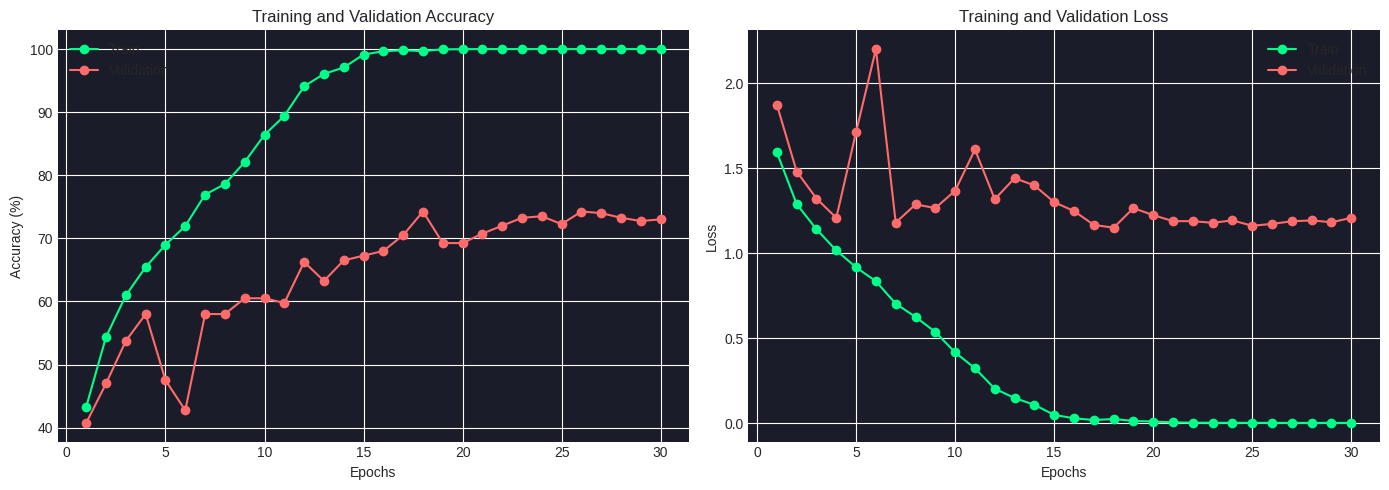

In [14]:
class FinalResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(FinalResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.activation = nn.GELU()

        self.layer1 = self._make_layer(32, 32, num_blocks=1, stride=1)
        self.layer2 = self._make_layer(32, 64, num_blocks=1, stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=1, stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock_CustomActivation(in_channels, out_channels, stride=stride, activation='gelu'))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock_CustomActivation(out_channels, out_channels, stride=1, activation='gelu'))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

print("ФИНАЛЬНАЯ МОДЕЛЬ")
print("- Каналы: 32 → 64 → 128 → 256")
print("- Количество блоков: [1, 1, 1, 1]")
print("- Активация: GELU")

final_model = FinalResNet18(num_classes=10)
print(f'\nКоличество параметров: {count_parameters(final_model):,}')

final_history = train_model(final_model, train_loader, val_loader, num_epochs=30, lr=0.001, device=device)

best_val_acc = max(final_history['val_acc'])
best_epoch = final_history['val_acc'].index(best_val_acc) + 1
print(f"\nЛучшая валидационная точность: {best_val_acc:.2f}% на эпохе {best_epoch}")

plot_training_results(final_history)

### 4.2: Тестирование на test set

Test Accuracy: 73.00%

МЕТРИКИ ПО КЛАССАМ
              precision    recall  f1-score   support

     Class 0     0.9412    0.9600    0.9505        50
     Class 1     0.6078    0.6200    0.6139        50
     Class 3     0.5532    0.5200    0.5361        50
     Class 4     0.7826    0.7200    0.7500        50
     Class 5     0.6949    0.8200    0.7523        50
     Class 6     0.8125    0.7800    0.7959        50
     Class 7     0.7091    0.7800    0.7429        50
     Class 8     0.7442    0.6400    0.6882        50

    accuracy                         0.7300       400
   macro avg     0.7307    0.7300    0.7287       400
weighted avg     0.7307    0.7300    0.7287       400

CONFUSION MATRIX



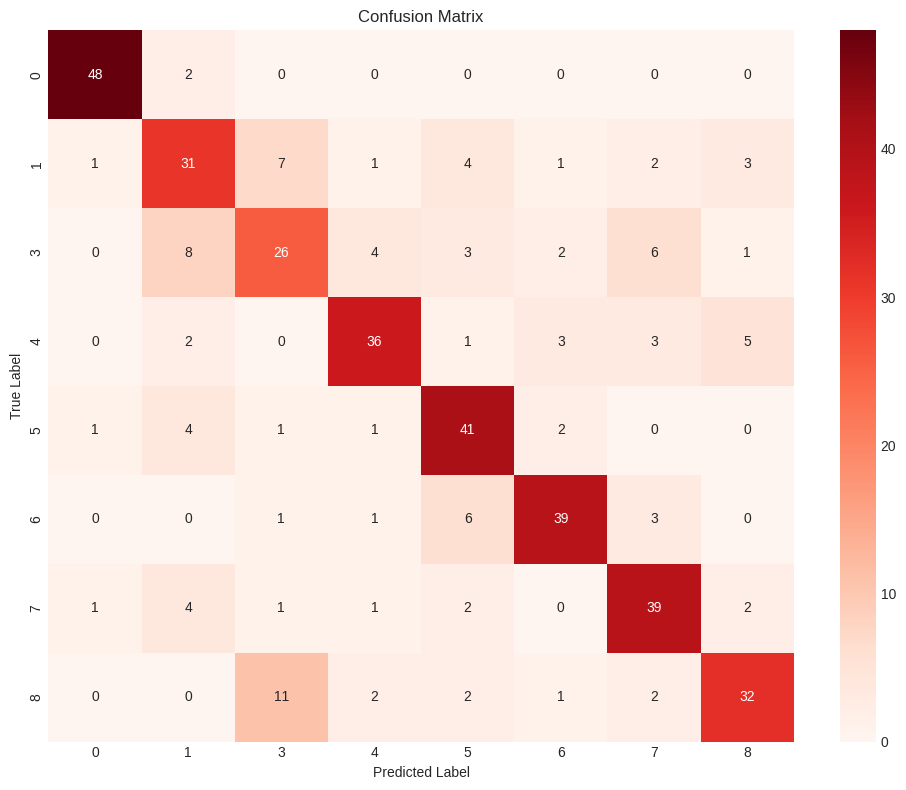

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, device):
    """Оценка модели на test set с расчетом метрик"""
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels

test_accuracy, test_preds, test_labels = evaluate_model(final_model, val_loader, device)

print(f"Test Accuracy: {test_accuracy:.2f}%\n")

print("МЕТРИКИ ПО КЛАССАМ")

unique_classes = sorted(np.unique(test_labels))
target_names = [f'Class {i}' for i in unique_classes]

print(classification_report(test_labels, test_preds, labels=unique_classes,
                           target_names=target_names, digits=4))

print("CONFUSION MATRIX\n")

cm = confusion_matrix(test_labels, test_preds, labels=unique_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### 4.3: Визуальный анализ

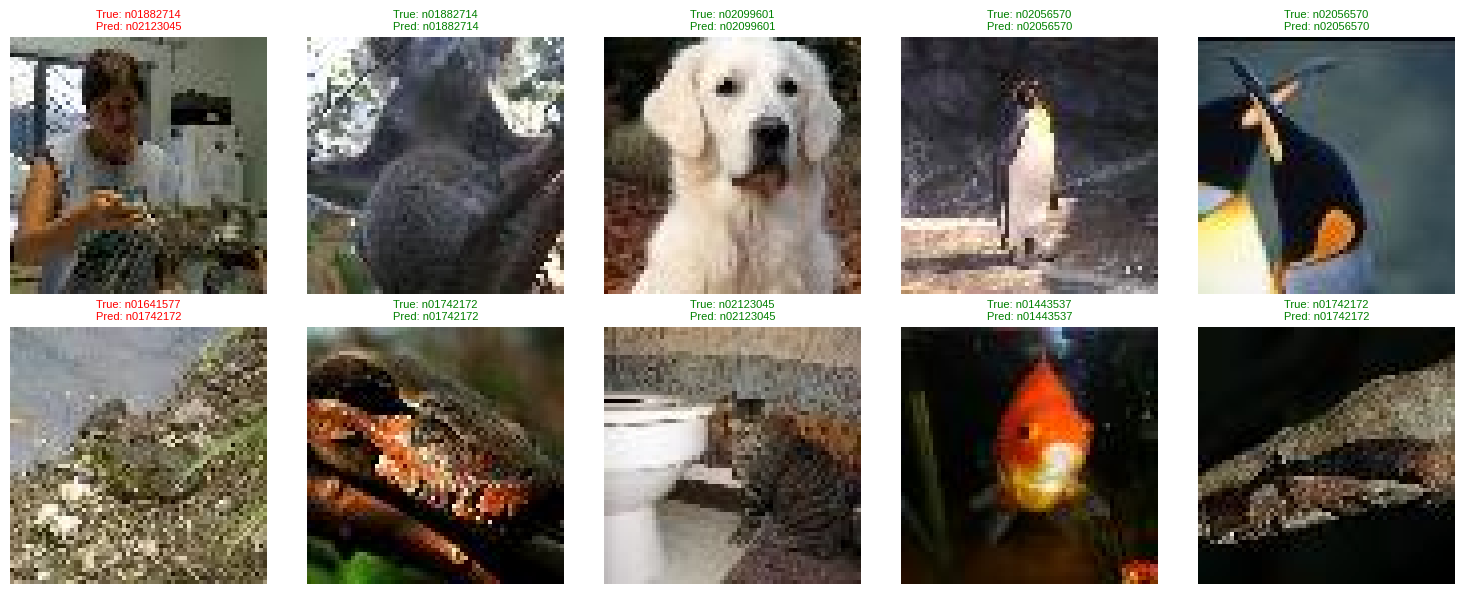

In [16]:
import random

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Денормализация изображения для визуализации"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def visualize_predictions(model, dataset, device, num_samples=10):
    """Визуализация предсказаний на случайных примерах"""
    model.eval()

    indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    class_names = SELECTED_CLASSES

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]

            # Предсказание
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            _, predicted = output.max(1)
            pred_label = predicted.item()

            # Денормализация для отображения
            img_display = denormalize(image)
            img_display = img_display.permute(1, 2, 0).numpy()

            # Отображение
            axes[i].imshow(img_display)
            axes[i].axis('off')

            true_class = class_names[true_label]
            pred_class = class_names[pred_label]

            color = 'green' if true_label == pred_label else 'red'
            axes[i].set_title(f'True: {true_class}\nPred: {pred_class}',
                            fontsize=8, color=color)

    plt.tight_layout()
    plt.show()

visualize_predictions(final_model, val_dataset, device, num_samples=10)

### 4.4: Сравнительная таблица всех экспериментов

In [17]:
import pandas as pd

data = {
    'Этап': [
        'Baseline',
        '3.1-A',
        '3.1-B',
        '3.2-A',
        '3.2-B',
        '3.2-C',
        '3.3-A',
        '3.3-B',
        '3.3-C',
        '3.3-D',
        'Final'
    ],
    'Конфигурация': [
        '64→128→256',
        '32→64→128→256',
        '64→128→256',
        '[1,1,1,1] блоков',
        '[2,2,2,2] блоков',
        '[3,3,3,3] блоков',
        'ReLU',
        'LeakyReLU',
        'ELU',
        'GELU',
        '32→64→128→256, [1,1,1,1], GELU'
    ],
    'Параметры': [
        f'{count_parameters(model_B)/1e6:.2f}M',
        f'{count_parameters(model_A)/1e6:.2f}M',
        f'{count_parameters(model_B)/1e6:.2f}M',
        f'{count_parameters(model_blocks_A)/1e6:.2f}M',
        f'{count_parameters(model_blocks_B)/1e6:.2f}M',
        f'{count_parameters(model_blocks_C)/1e6:.2f}M',
        f'{count_parameters(model_relu)/1e6:.2f}M',
        f'{count_parameters(model_leakyrelu)/1e6:.2f}M',
        f'{count_parameters(model_elu)/1e6:.2f}M',
        f'{count_parameters(model_gelu)/1e6:.2f}M',
        f'{count_parameters(final_model)/1e6:.2f}M'
    ],
    'Val Accuracy': [
        f'{max(history_B["val_acc"]):.2f}%',
        f'{max(history_A["val_acc"]):.2f}%',
        f'{max(history_B["val_acc"]):.2f}%',
        f'{max(history_blocks_A["val_acc"]):.2f}%',
        f'{max(history_blocks_B["val_acc"]):.2f}%',
        f'{max(history_blocks_C["val_acc"]):.2f}%',
        f'{max(history_relu["val_acc"]):.2f}%',
        f'{max(history_leakyrelu["val_acc"]):.2f}%',
        f'{max(history_elu["val_acc"]):.2f}%',
        f'{max(history_gelu["val_acc"]):.2f}%',
        f'{max(final_history["val_acc"]):.2f}%'
    ],
    'Train Accuracy': [
        f'{max(history_B["train_acc"]):.2f}%',
        f'{max(history_A["train_acc"]):.2f}%',
        f'{max(history_B["train_acc"]):.2f}%',
        f'{max(history_blocks_A["train_acc"]):.2f}%',
        f'{max(history_blocks_B["train_acc"]):.2f}%',
        f'{max(history_blocks_C["train_acc"]):.2f}%',
        f'{max(history_relu["train_acc"]):.2f}%',
        f'{max(history_leakyrelu["train_acc"]):.2f}%',
        f'{max(history_elu["train_acc"]):.2f}%',
        f'{max(history_gelu["train_acc"]):.2f}%',
        f'{max(final_history["train_acc"]):.2f}%'
    ]
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

best_config = df.loc[df['Val Accuracy'].apply(lambda x: float(x.strip('%'))).idxmax()]
print(f"\nЛучшая конфигурация: {best_config['Этап']} - {best_config['Конфигурация']}")
print(f"Val Accuracy: {best_config['Val Accuracy']}")

    Этап                   Конфигурация Параметры Val Accuracy Train Accuracy
Baseline                     64→128→256     2.78M       64.50%         83.28%
   3.1-A                  32→64→128→256     2.80M       70.75%         95.40%
   3.1-B                     64→128→256     2.78M       64.50%         83.28%
   3.2-A               [1,1,1,1] блоков     1.23M       67.00%        100.00%
   3.2-B               [2,2,2,2] блоков     2.80M       71.00%         97.20%
   3.2-C               [3,3,3,3] блоков     4.37M       68.75%         92.95%
   3.3-A                           ReLU     1.23M       67.00%         99.20%
   3.3-B                      LeakyReLU     1.23M       70.25%         99.92%
   3.3-C                            ELU     1.23M       62.50%         83.62%
   3.3-D                           GELU     1.23M       68.50%         99.97%
   Final 32→64→128→256, [1,1,1,1], GELU     1.23M       74.25%        100.00%

Лучшая конфигурация: Final - 32→64→128→256, [1,1,1,1], GELU
Val

Результаты на отложенной выборке (val):

Final Test Accuracy: 73.00%. Результат близок к лучшей валидационной точности (74.25%), что подтверждает адекватность оценки.

Виден дисбаланс в качестве предсказаний. Например, для Class 0 точность (precision) и полнота (recall) > 94%, а для Class 1 и Class 3 эти метрики около 55-62%. Это говорит о том, что модель хорошо отличает одни классы, но путает другие, вероятно, из-за их визуальной схожести в рамках Tiny ImageNet.

Confusion Matrix: Наглядно показывает, между какими конкретно классами происходит основная путаница.

Вывод:

Модель успешно обобщается, финальная accuracy на тестовых данных практически соответствует валидационной.

Главная проблема — неоднородность качества классификации.